In [1]:
#常用工具库
import re
import numpy as np
import pandas as pd
import matplotlib as mlp
import matplotlib.pyplot as plt
import seaborn as sns
import time

#算法辅助 & 数据

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import sklearn
from sklearn.model_selection import KFold, cross_validate
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import sklearn.metrics as skmet
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_auc_score,roc_curve
from sklearn.metrics import confusion_matrix, recall_score,f1_score,accuracy_score,auc
#算法（单一学习器）
from sklearn.neighbors import KNeighborsClassifier as KNNC
from sklearn.ensemble import AdaBoostClassifier , RandomForestClassifier,GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.linear_model import LogisticRegression
#融合模型
from sklearn.ensemble import StackingClassifier

In [2]:
df = pd.read_csv("wrapper_63.csv")

In [3]:
# X提取变量特征；Y提取目标变量
X = df.drop('label', axis=1)
y = df['label']
Xtrain,Xtest,Ytrain,Ytest = train_test_split(X,y,test_size=0.3,random_state=100)

In [4]:
def fusion_estimators(clf):
    cv = KFold(n_splits=5,shuffle=True,random_state=100)
    results = cross_validate(clf,Xtrain,Ytrain
                             ,cv = cv
                             ,scoring = "accuracy"
                             ,n_jobs = -1
                             ,return_train_score = True
                             ,verbose=False)
    
    test = clf.fit(Xtrain,Ytrain).score(Xtest,Ytest)
    print("train_score:{}".format(results["train_score"].mean())
          ,"\n cv_mean:{}".format(results["test_score"].mean())
          ,"\n test_score:{}".format(test)
         )

In [5]:
def individual_estimators(estimators):
    for estimator in estimators:
        cv = KFold(n_splits=5,shuffle=True,random_state=100)
        results = cross_validate(estimator[1],Xtrain,Ytrain
                             ,cv = cv
                             ,scoring = "accuracy"
                             ,n_jobs = -1
                             ,return_train_score = True
                             ,verbose=False)
        
        test = estimator[1].fit(Xtrain,Ytrain).score(Xtest,Ytest)
        print(estimator[0]
          ,"\n train_score:{}".format(results["train_score"].mean())
          ,"\n cv_mean:{}".format(results["test_score"].mean())
          ,"\n test_score:{}".format(test)
          ,"\n")

In [6]:
# 模型调参

In [7]:
SEED = 100
model_RF=RandomForestClassifier(class_weight="balanced", max_depth=7, max_leaf_nodes=60,
                       min_samples_split=3, n_estimators=130, random_state=420)
model_SVC = SVC(kernel='linear',class_weight="balanced",random_state = 420, probability=True)
model_GB = GradientBoostingClassifier(learning_rate=0.3, max_depth=3, min_samples_leaf=3,
                           n_estimators=70, random_state=420)
model_AB  = AdaBoostClassifier(learning_rate=0.2, n_estimators=20, random_state=420)
model_xgboost = xgb.XGBClassifier(eta=0.008,gamma=0.1,max_depth=4, n_estimators=60, max_delta_step=2,min_child_weight=9,random_state = 420)

In [8]:
estimators=[("RF",model_RF )
            , ("SVC", model_SVC)
              , ("GBT",model_GB),  ("AB",model_AB)
            ,("xgboost",model_xgboost)
            ]

In [35]:
final_estimator = RFC(n_estimators=140
                      , min_impurity_decrease=0.0001
                      ,class_weight="balanced"
                      , random_state=420, n_jobs=8)
final_model = StackingClassifier(estimators=estimators
                         ,final_estimator=final_estimator
                         ,cv = 5       
                         ,stack_method = "auto"
                         ,n_jobs=8).fit(Xtrain,Ytrain)

In [9]:
final_estimator = LogisticRegression(C = 0.1,multi_class='multinomial' ,random_state=420)
final_model = StackingClassifier(estimators=estimators
                         ,final_estimator=final_estimator
                         ,cv = 5       
                         ,stack_method = "auto"
                         ,n_jobs=8).fit(Xtrain,Ytrain)

In [10]:
fusion_estimators(final_model)#(0.01)

train_score:0.9758928571428571 
 cv_mean:0.8416666666666668 
 test_score:0.8611111111111112


In [36]:
fusion_estimators(final_model)#(0.1)

train_score:0.9467261904761906 
 cv_mean:0.8321428571428573 
 test_score:0.8555555555555555


In [11]:
individual_estimators(estimators)

RF 
 train_score:0.9568452380952381 
 cv_mean:0.8345238095238094 
 test_score:0.85 

SVC 
 train_score:0.88125 
 cv_mean:0.8178571428571427 
 test_score:0.8361111111111111 

GBT 
 train_score:1.0 
 cv_mean:0.830952380952381 
 test_score:0.8444444444444444 

AB 
 train_score:0.8476190476190476 
 cv_mean:0.8214285714285715 
 test_score:0.825 

xgboost 
 train_score:0.8827380952380952 
 cv_mean:0.8261904761904763 
 test_score:0.8305555555555556 



params = {
          'final_estimator__C':np.arange(0.1, 10, 0.5)
         }
         

params = {'final_estimator__n_estimators': np.arange(80, 140, 10)
          ,'final_estimator__min_impurity_decrease':[0.001,0.005,0.008,0.01,0.05,0.08]
         }

grid = GridSearchCV(estimator=final_model, 
                    param_grid=params, 
                    cv=5,
                    refit=True)
grid.fit(X, y)


print('最佳参数：', grid.best_params_)

In [12]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
models =  [model_RF,model_SVC, model_GB, model_AB,model_xgboost,final_model]
names =['RF','SVC','GBT','AB','xgboost','Stacking' ]

/home/ubuntu/miniconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


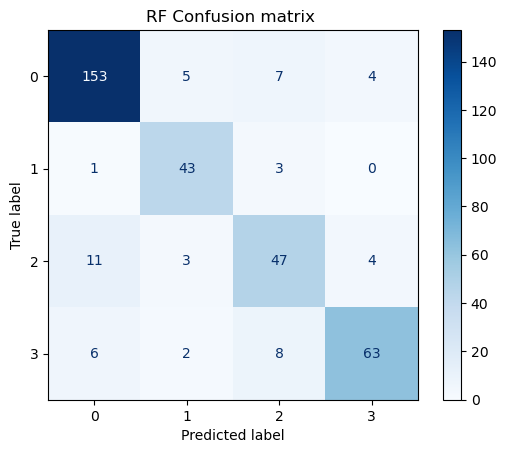

/home/ubuntu/miniconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


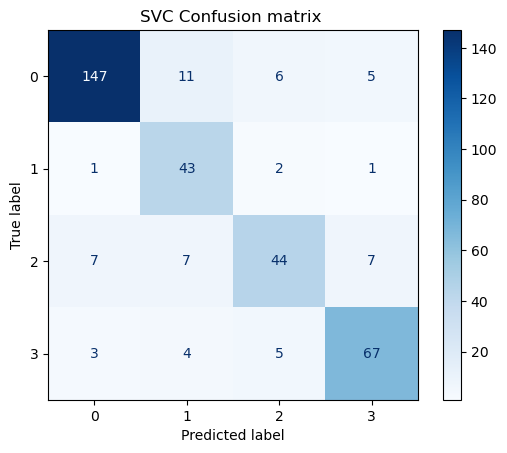

/home/ubuntu/miniconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


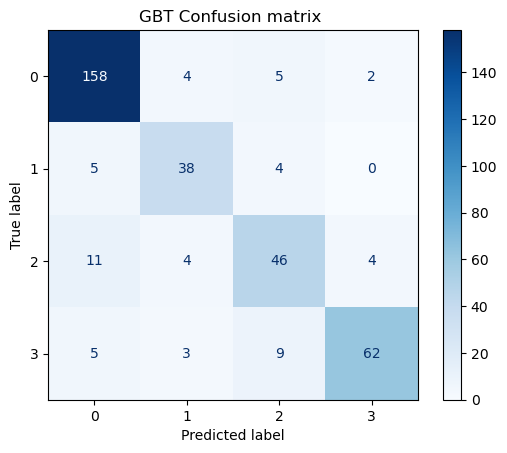

/home/ubuntu/miniconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


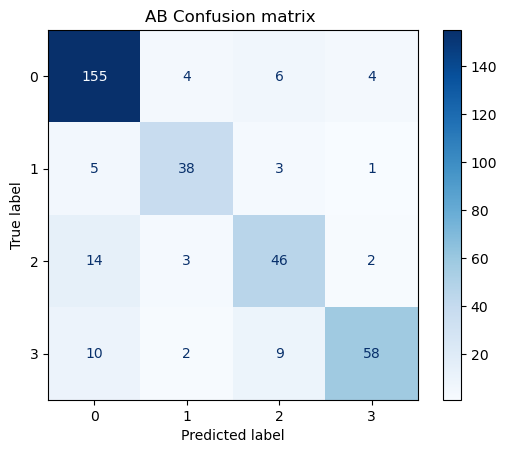

/home/ubuntu/miniconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


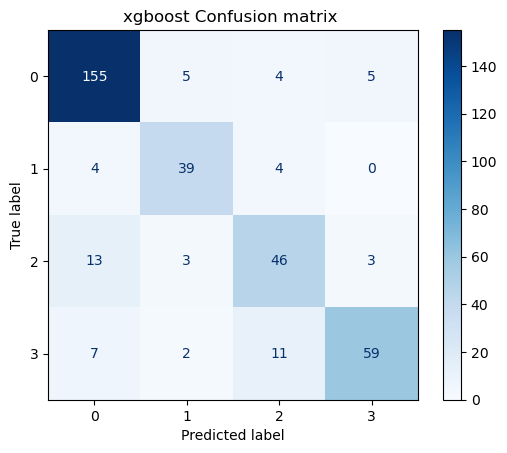

/home/ubuntu/miniconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


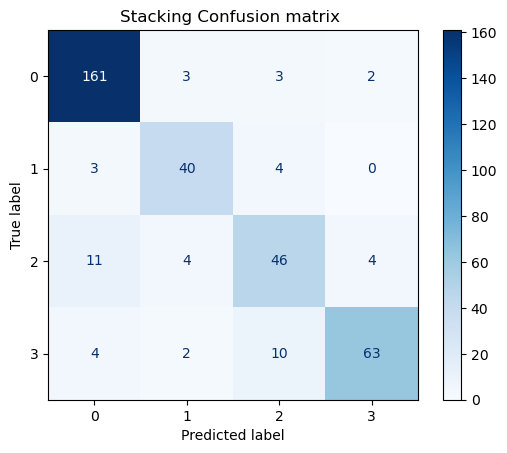

In [13]:
for (name, model) in zip(names, models):
    matrix = plot_confusion_matrix(model, Xtest, Ytest,
                                 cmap=plt.cm.Blues,
#                                  include_values = 'true' 
#                                  normalize='true'
                                  )
    
    plt.title('{} Confusion matrix '.format(name))
    plt.savefig('{} Confusion matrix '.format(name),dpi=1000,bbox_inches = 'tight')
    plt.show(matrix)
    plt.show()


labels =[0,1,2,3]
for (name, model) in zip(names, models):
    pred_enn = model.predict(Xtest)
    skmet.confusion_matrix(Ytest,pred_enn)
    print(name)
    print(skmet.classification_report(Ytest,pred_enn))
    matrix_enn = confusion_matrix(Ytest, pred_enn)
    print(matrix_enn)
    recall = recall_score(Ytest, pred_enn,labels=labels, average="macro")
    print('recall:',recall)
    acc = accuracy_score(Ytest, pred_enn)
    print('accuracy:',acc)
    f1 = f1_score(Ytest, pred_enn, average="macro")
    print("f1_score:",f1)

In [14]:
import numpy as np
import sklearn.metrics as skmet

def specificity_score(y_true, y_pred, target_class):
    cm = skmet.confusion_matrix(y_true, y_pred)
    num_classes = cm.shape[0]
    
    # True negatives (TN) for the target class
    tn = sum(cm[i, j] for i in range(num_classes) for j in range(num_classes) if i != target_class and j != target_class)
    
    # False positives (FP) for the target class
    fp = sum(cm[i, target_class] for i in range(num_classes) if i != target_class)
    
    # Specificity for the target class
    specificity = tn / (tn + fp)
    return specificity

labels = [0, 1, 2, 3]

for (name, model) in zip(names, models):
    pred_enn = model.predict(Xtest)
    matrix_enn = skmet.confusion_matrix(Ytest, pred_enn)
    print(name)
    print(skmet.classification_report(Ytest, pred_enn))
    print(matrix_enn)
    recall = skmet.recall_score(Ytest, pred_enn, labels=labels, average="macro")
    print('recall:', recall)
    acc = skmet.accuracy_score(Ytest, pred_enn)
    print('accuracy:', acc)
    f1 = skmet.f1_score(Ytest, pred_enn, average="macro")
    print("f1_score:", f1)
    
    # Calculate and print specificity for each class
    model_specificity = []
    for target_class in labels:
        specificity = specificity_score(Ytest, pred_enn, target_class)
        model_specificity.append(specificity)
        print("Specificity for class {}: {:.3f}".format(target_class, specificity))

        
        # Calculate and print overall specificity (average specificity)
    overall_specificity = np.mean(model_specificity)
    print("Overall Specificity: {:.3f}".format(overall_specificity))

RF
              precision    recall  f1-score   support

           0       0.89      0.91      0.90       169
           1       0.81      0.91      0.86        47
           2       0.72      0.72      0.72        65
           3       0.89      0.80      0.84        79

    accuracy                           0.85       360
   macro avg       0.83      0.84      0.83       360
weighted avg       0.85      0.85      0.85       360

[[153   5   7   4]
 [  1  43   3   0]
 [ 11   3  47   4]
 [  6   2   8  63]]
recall: 0.8351910845788904
accuracy: 0.85
f1_score: 0.8307692307692307
Specificity for class 0: 0.906
Specificity for class 1: 0.968
Specificity for class 2: 0.939
Specificity for class 3: 0.972
Overall Specificity: 0.946
SVC
              precision    recall  f1-score   support

           0       0.93      0.87      0.90       169
           1       0.66      0.91      0.77        47
           2       0.77      0.68      0.72        65
           3       0.84      0.85      0.8

/home/ubuntu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


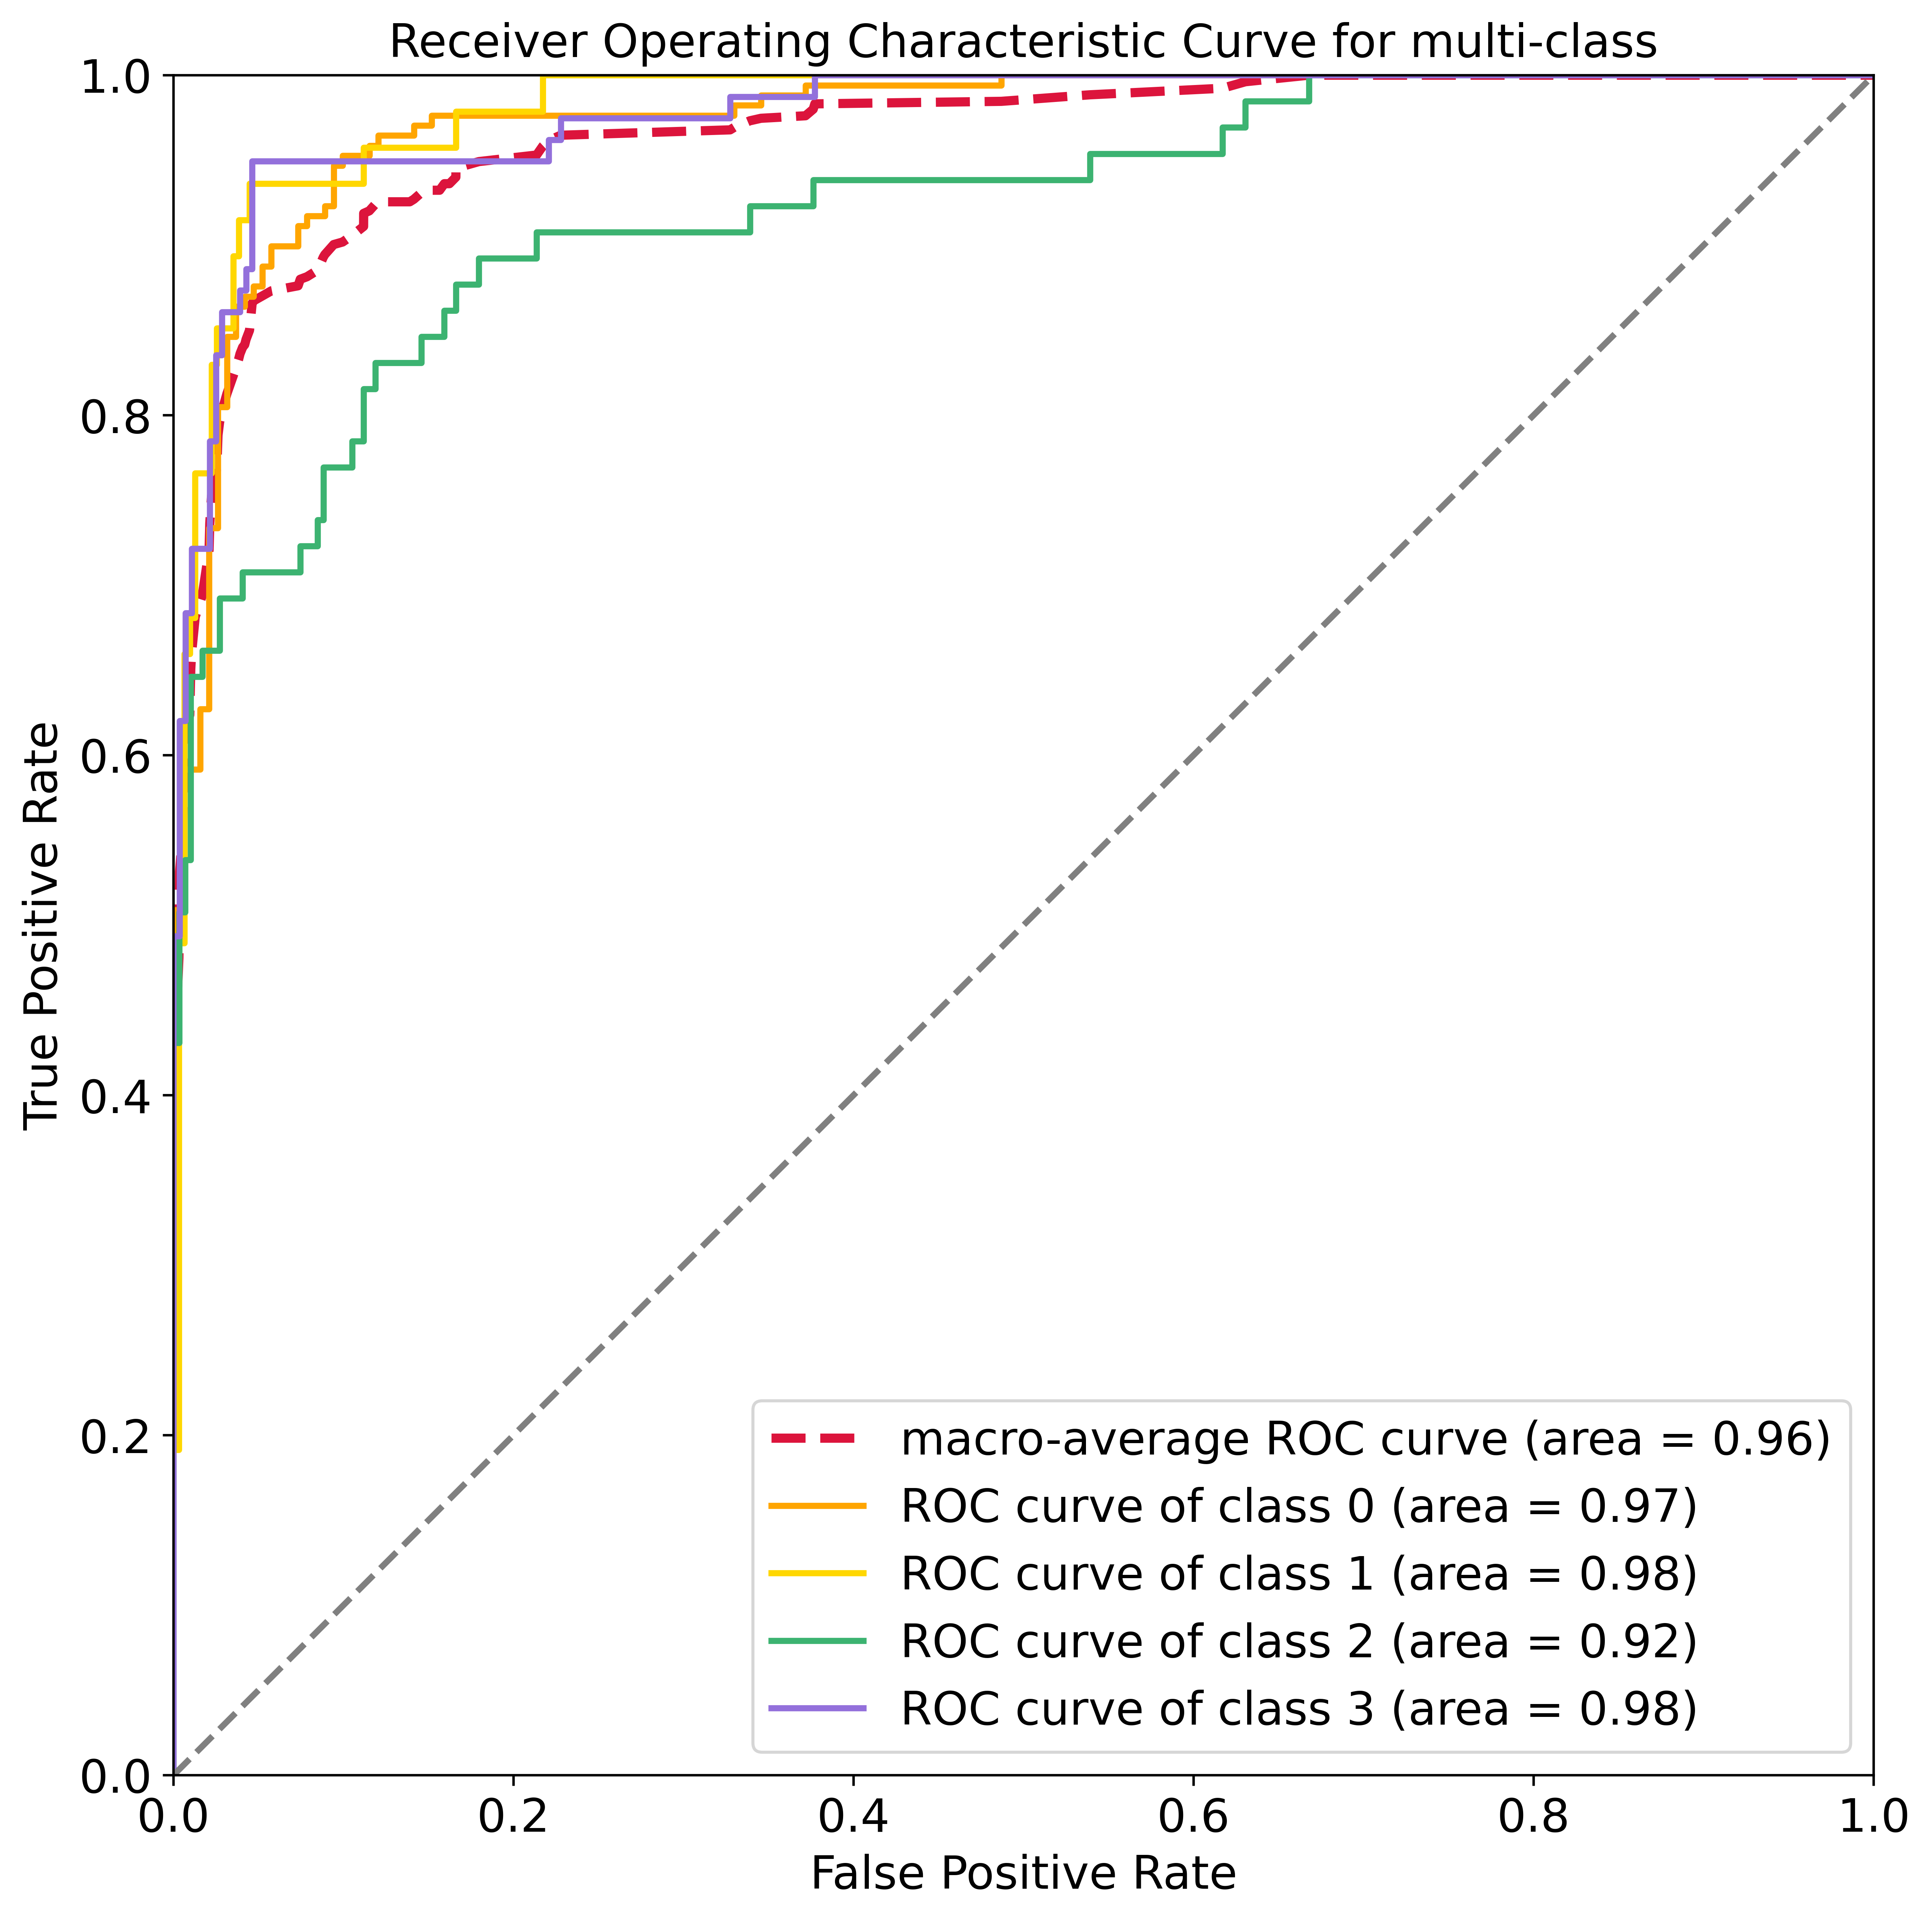

In [15]:
from scipy import interp
from sklearn.preprocessing import label_binarize

colors = [
          'orange',
          'gold',
          'mediumseagreen', 
          'mediumpurple'
        ]
y_score = final_model.predict_proba(Xtest) 
# 将标签二值化
y_test = label_binarize(Ytest, classes=[0, 1, 2,3]) # 三个类别
 # 设置种类
n_classes =y_test.shape[1]

# 计算每一类的ROC
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Compute macro-average ROC curve and ROC area（方法一）
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])
    
    
# Finally average it and compute AUC
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.figure(figsize=(10, 10),dpi=600)    
plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='crimson', linestyle='--', linewidth=3)    

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))


plt.plot([0, 1], [0, 1], '--', lw=2, color='grey')
plt.axis('square')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.tick_params(labelsize=15)
plt.xlabel('False Positive Rate',fontsize=15)
plt.ylabel('True Positive Rate',fontsize=15)
plt.title('Receiver Operating Characteristic Curve for multi-class',fontsize=15)
plt.legend(loc="lower right",fontsize=15)
plt.savefig('ROC_mul.png', dpi=1000, bbox_inches='tight')
plt.show()



/home/ubuntu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


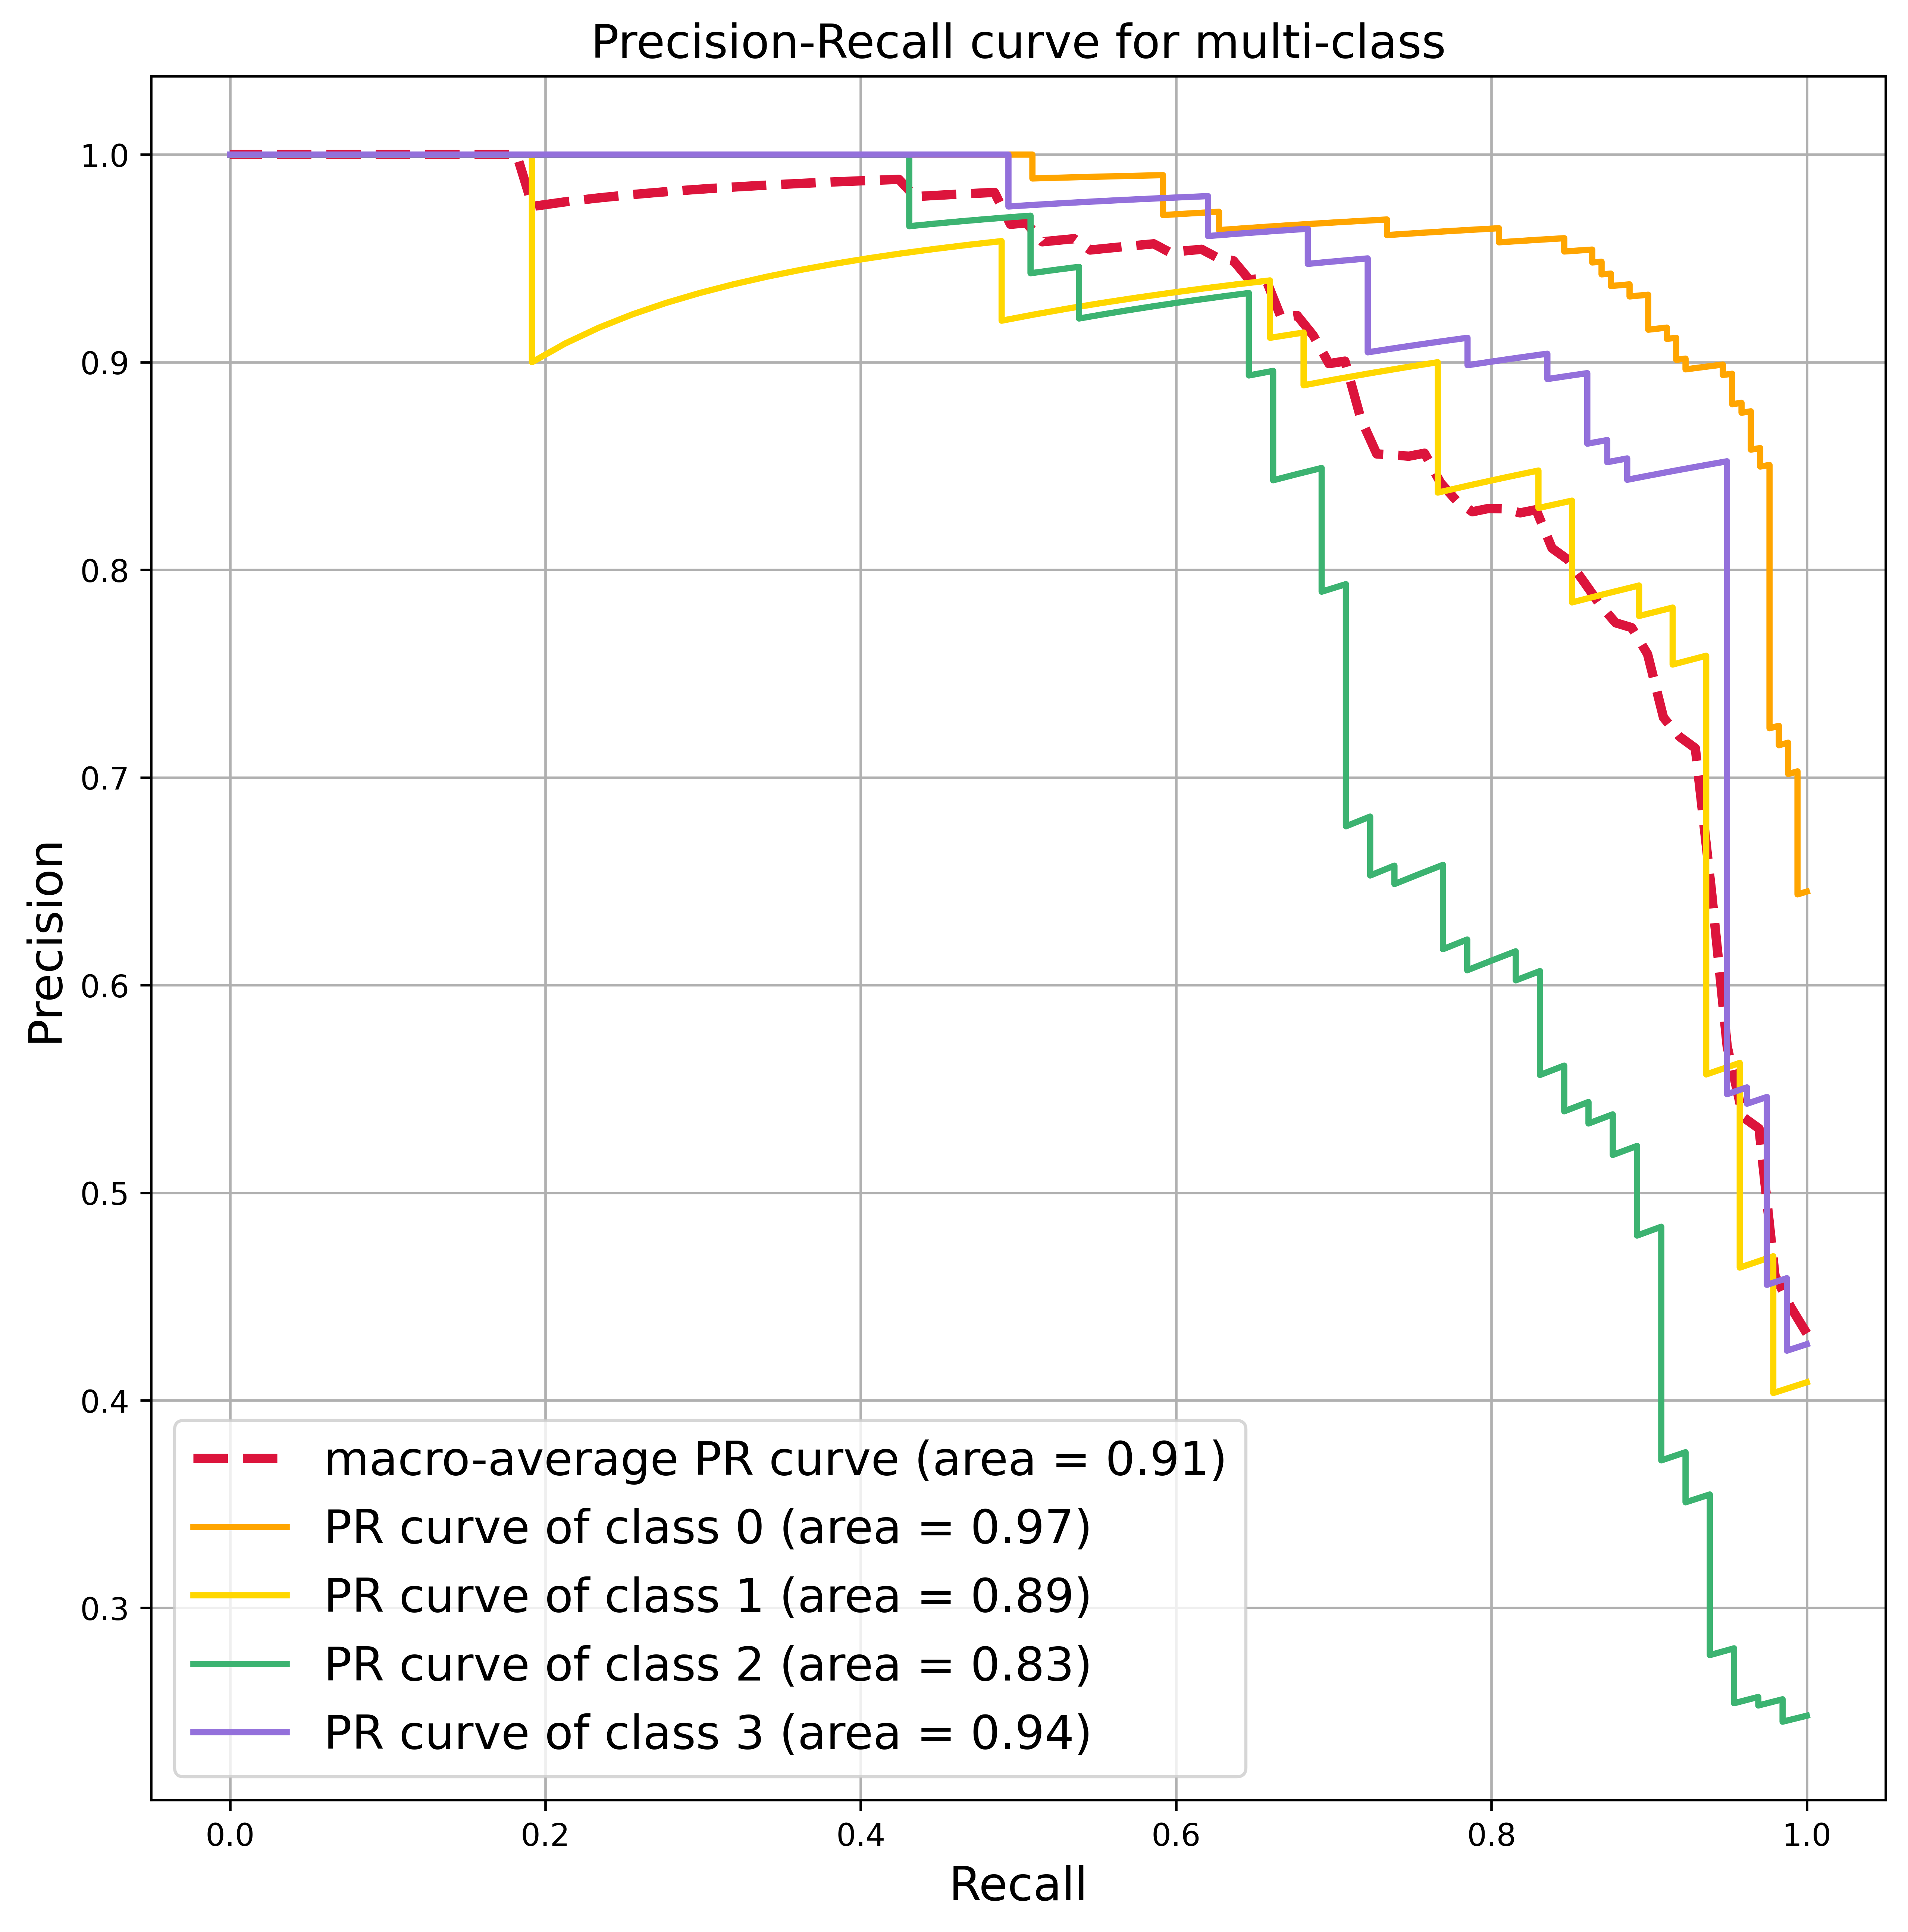

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc
from sklearn.preprocessing import label_binarize
from scipy import interp

colors = ['orange', 'gold', 'mediumseagreen', 'mediumpurple']
y_score = final_model.predict_proba(Xtest)
y_test = label_binarize(Ytest, classes=[0, 1, 2, 3])  # Four classes
n_classes = y_test.shape[1]

precision = dict()
recall = dict()
pr_auc = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], y_score[:, i])
    pr_auc[i] = auc(recall[i], precision[i])

# Compute macro-average PR curve and PR AUC (method one)
all_recall = np.linspace(0, 1, 100)

mean_precision = np.zeros_like(all_recall)
for i in range(n_classes):
    mean_precision += interp(all_recall, recall[i][::-1], precision[i][::-1])

mean_precision /= n_classes
recall["macro"] = all_recall[::-1]
precision["macro"] = mean_precision[::-1]
pr_auc["macro"] = auc(recall["macro"], precision["macro"])

plt.figure(figsize=(10, 10), dpi=600)
plt.plot(recall["macro"], precision["macro"],
         label='macro-average PR curve (area = {0:0.2f})'
               ''.format(pr_auc["macro"]),
         color='crimson', linestyle='--', linewidth=3)

for i, color in zip(range(n_classes), colors):
    plt.plot(recall[i], precision[i], color=color, lw=2,
             label='PR curve of class {0} (area = {1:0.2f})'
                   ''.format(i, pr_auc[i]))

plt.xlabel('Recall', fontsize=15)
plt.ylabel('Precision', fontsize=15)
plt.title('Precision-Recall curve for multi-class', fontsize=15)
plt.legend(loc="lower left", fontsize=15)
plt.grid(True)
plt.savefig('PR curve.png', dpi=1000, bbox_inches='tight')
plt.show()


/home/ubuntu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/ubuntu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


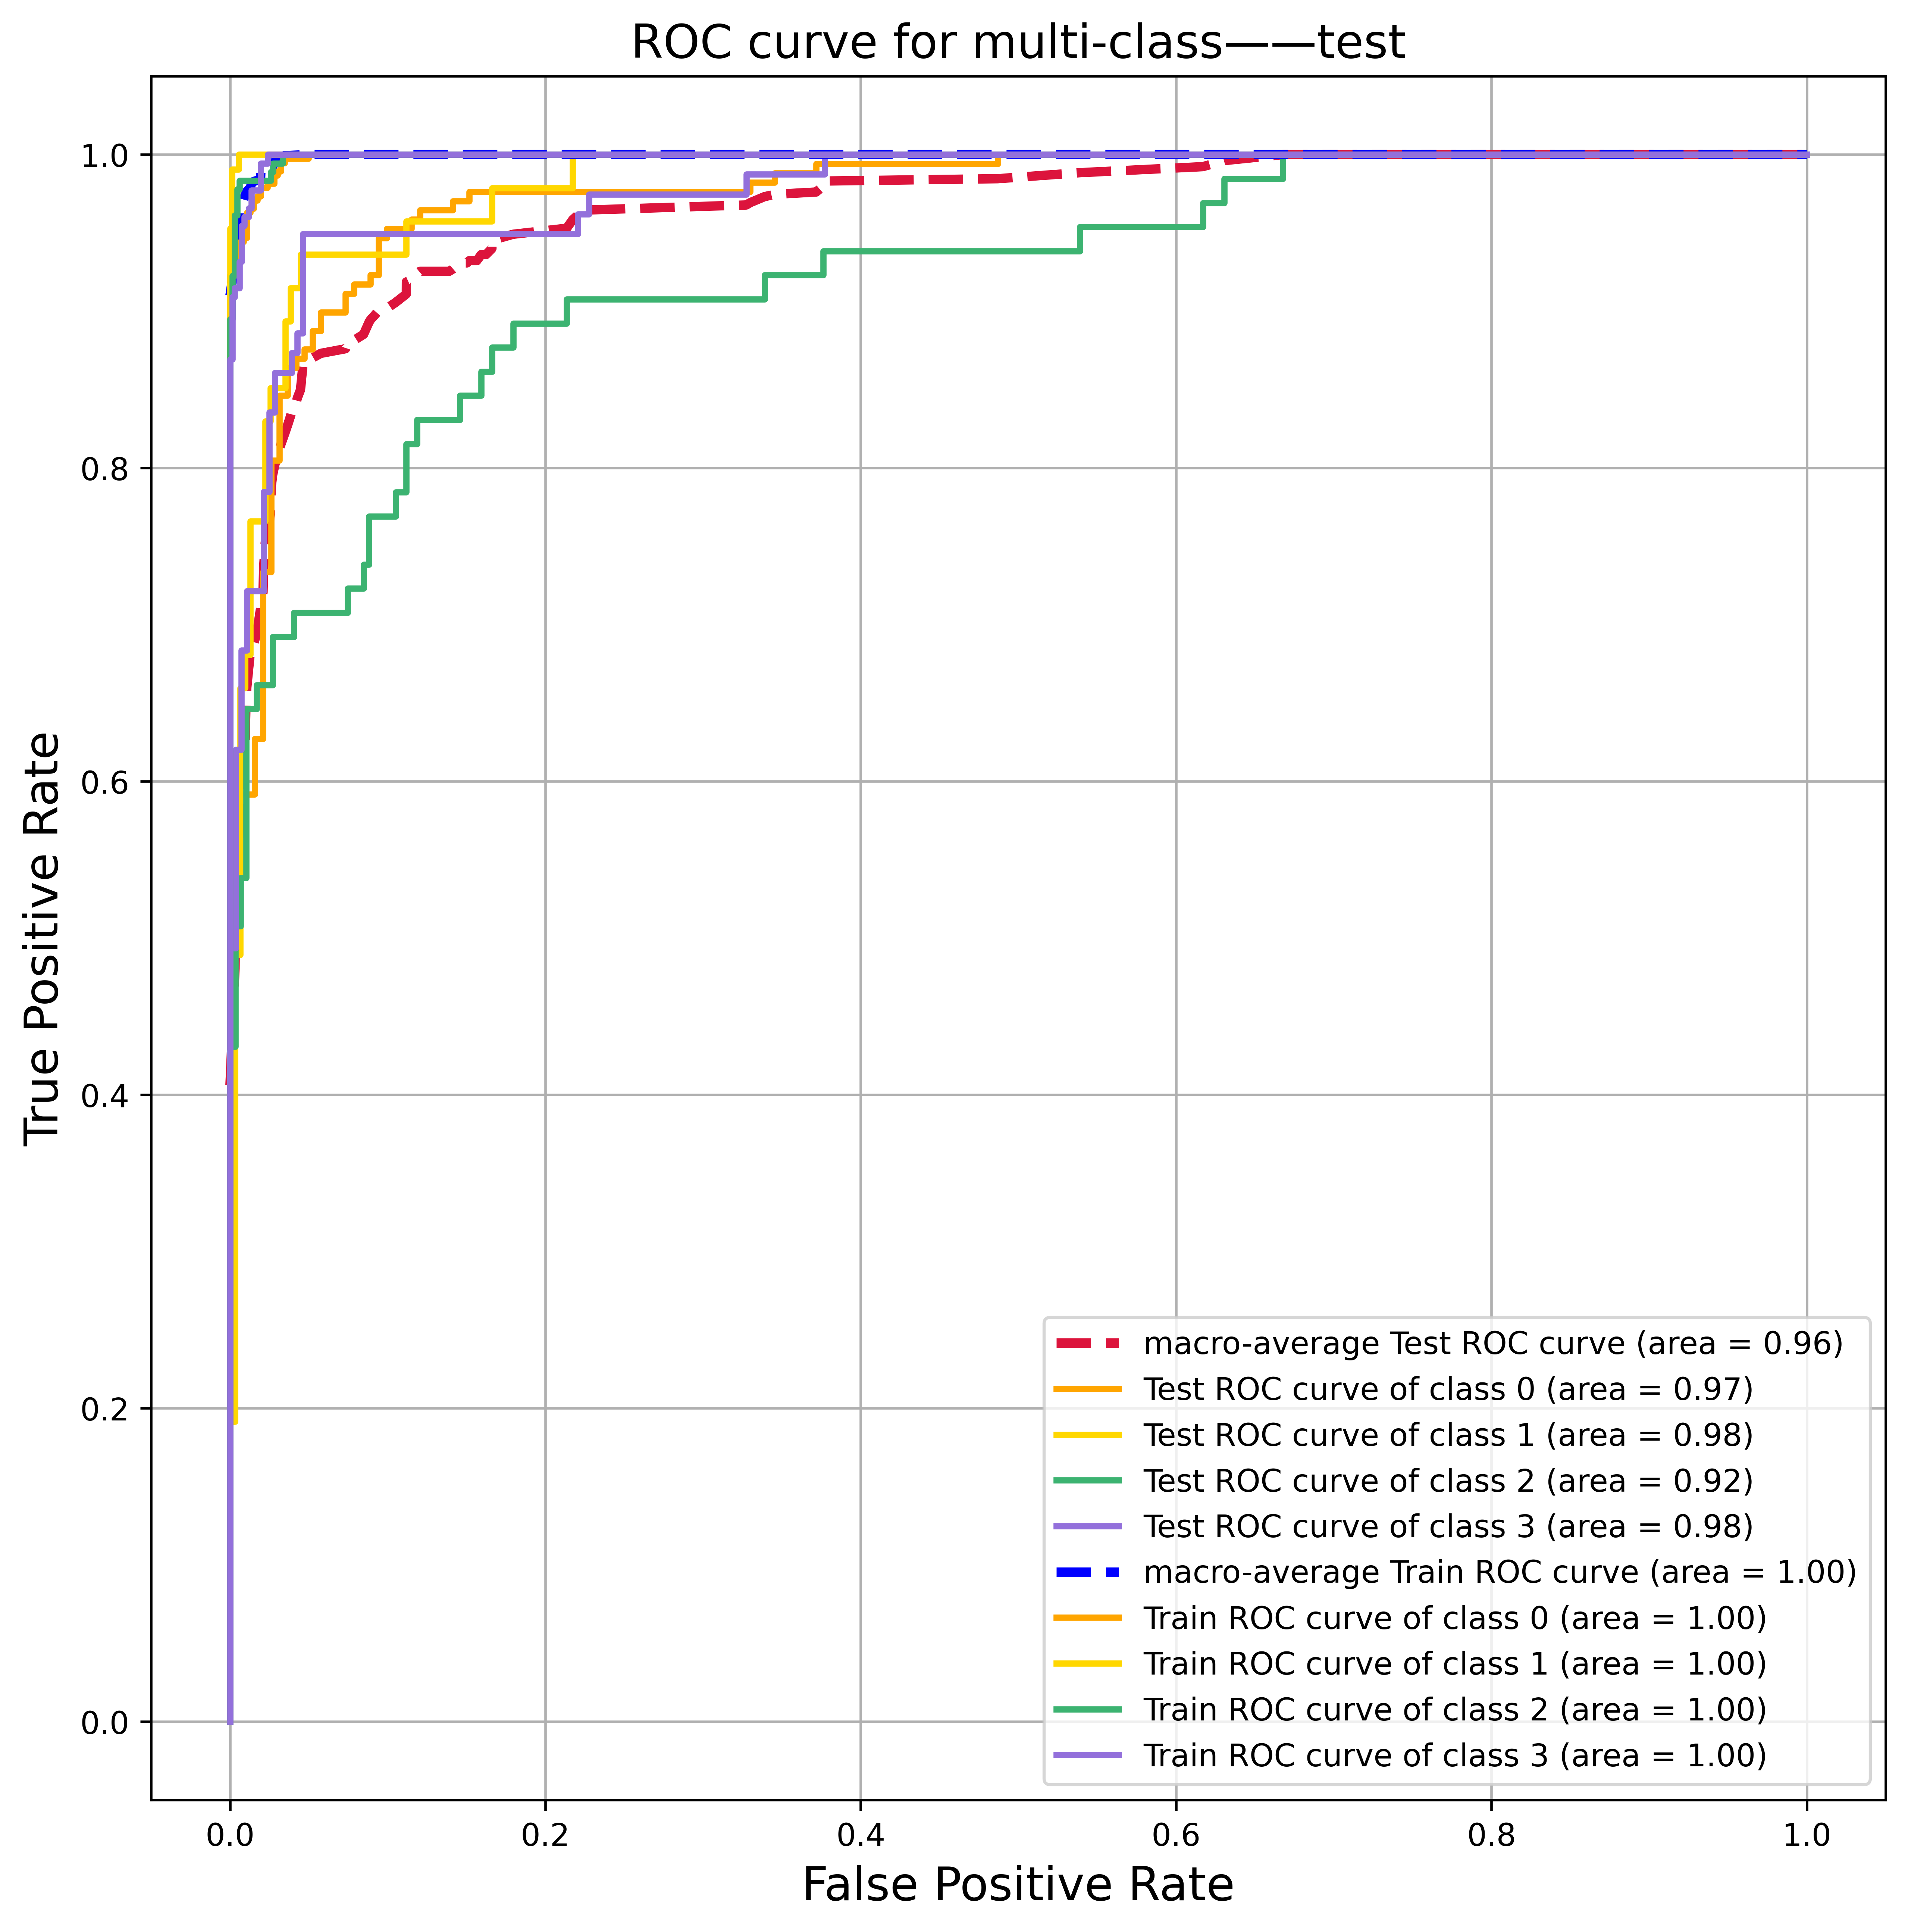

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy import interp

colors = ['orange', 'gold', 'mediumseagreen', 'mediumpurple']

# Predict probabilities for both training and testing sets
y_score_test = final_model.predict_proba(Xtest)
y_score_train = final_model.predict_proba(Xtrain)

# Binarize the labels for both sets
y_test = label_binarize(Ytest, classes=[0, 1, 2, 3])  # Four classes
y_train = label_binarize(Ytrain, classes=[0, 1, 2, 3])  # Four classes

n_classes = y_test.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()

# Calculate ROC curve and AUC for each class for the testing set
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score_test[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute macro-average ROC curve and ROC AUC for the testing set
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)

for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Calculate ROC curve and AUC for each class for the training set
fpr_train = dict()
tpr_train = dict()
roc_auc_train = dict()

for i in range(n_classes):
    fpr_train[i], tpr_train[i], _ = roc_curve(y_train[:, i], y_score_train[:, i])
    roc_auc_train[i] = auc(fpr_train[i], tpr_train[i])

# Compute macro-average ROC curve and ROC AUC for the training set
all_fpr_train = np.unique(np.concatenate([fpr_train[i] for i in range(n_classes)]))
mean_tpr_train = np.zeros_like(all_fpr_train)

for i in range(n_classes):
    mean_tpr_train += interp(all_fpr_train, fpr_train[i], tpr_train[i])

mean_tpr_train /= n_classes
fpr_train["macro"] = all_fpr_train
tpr_train["macro"] = mean_tpr_train
roc_auc_train["macro"] = auc(fpr_train["macro"], tpr_train["macro"])

plt.figure(figsize=(10, 10), dpi=600)

# Plot the ROC curves for the testing set
plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average Test ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='crimson', linestyle='--', linewidth=3)

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='Test ROC curve of class {0} (area = {1:0.2f})'
                   ''.format(i, roc_auc[i]))

# Plot the ROC curves for the training set
plt.plot(fpr_train["macro"], tpr_train["macro"],
         label='macro-average Train ROC curve (area = {0:0.2f})'
               ''.format(roc_auc_train["macro"]),
         color='blue', linestyle='--', linewidth=3)

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr_train[i], tpr_train[i], color=color, lw=2,
             label='Train ROC curve of class {0} (area = {1:0.2f})'
                   ''.format(i, roc_auc_train[i]))

plt.xlabel('False Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
plt.title('ROC curve for multi-class——test', fontsize=15)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True)
plt.show()


/home/ubuntu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/ubuntu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


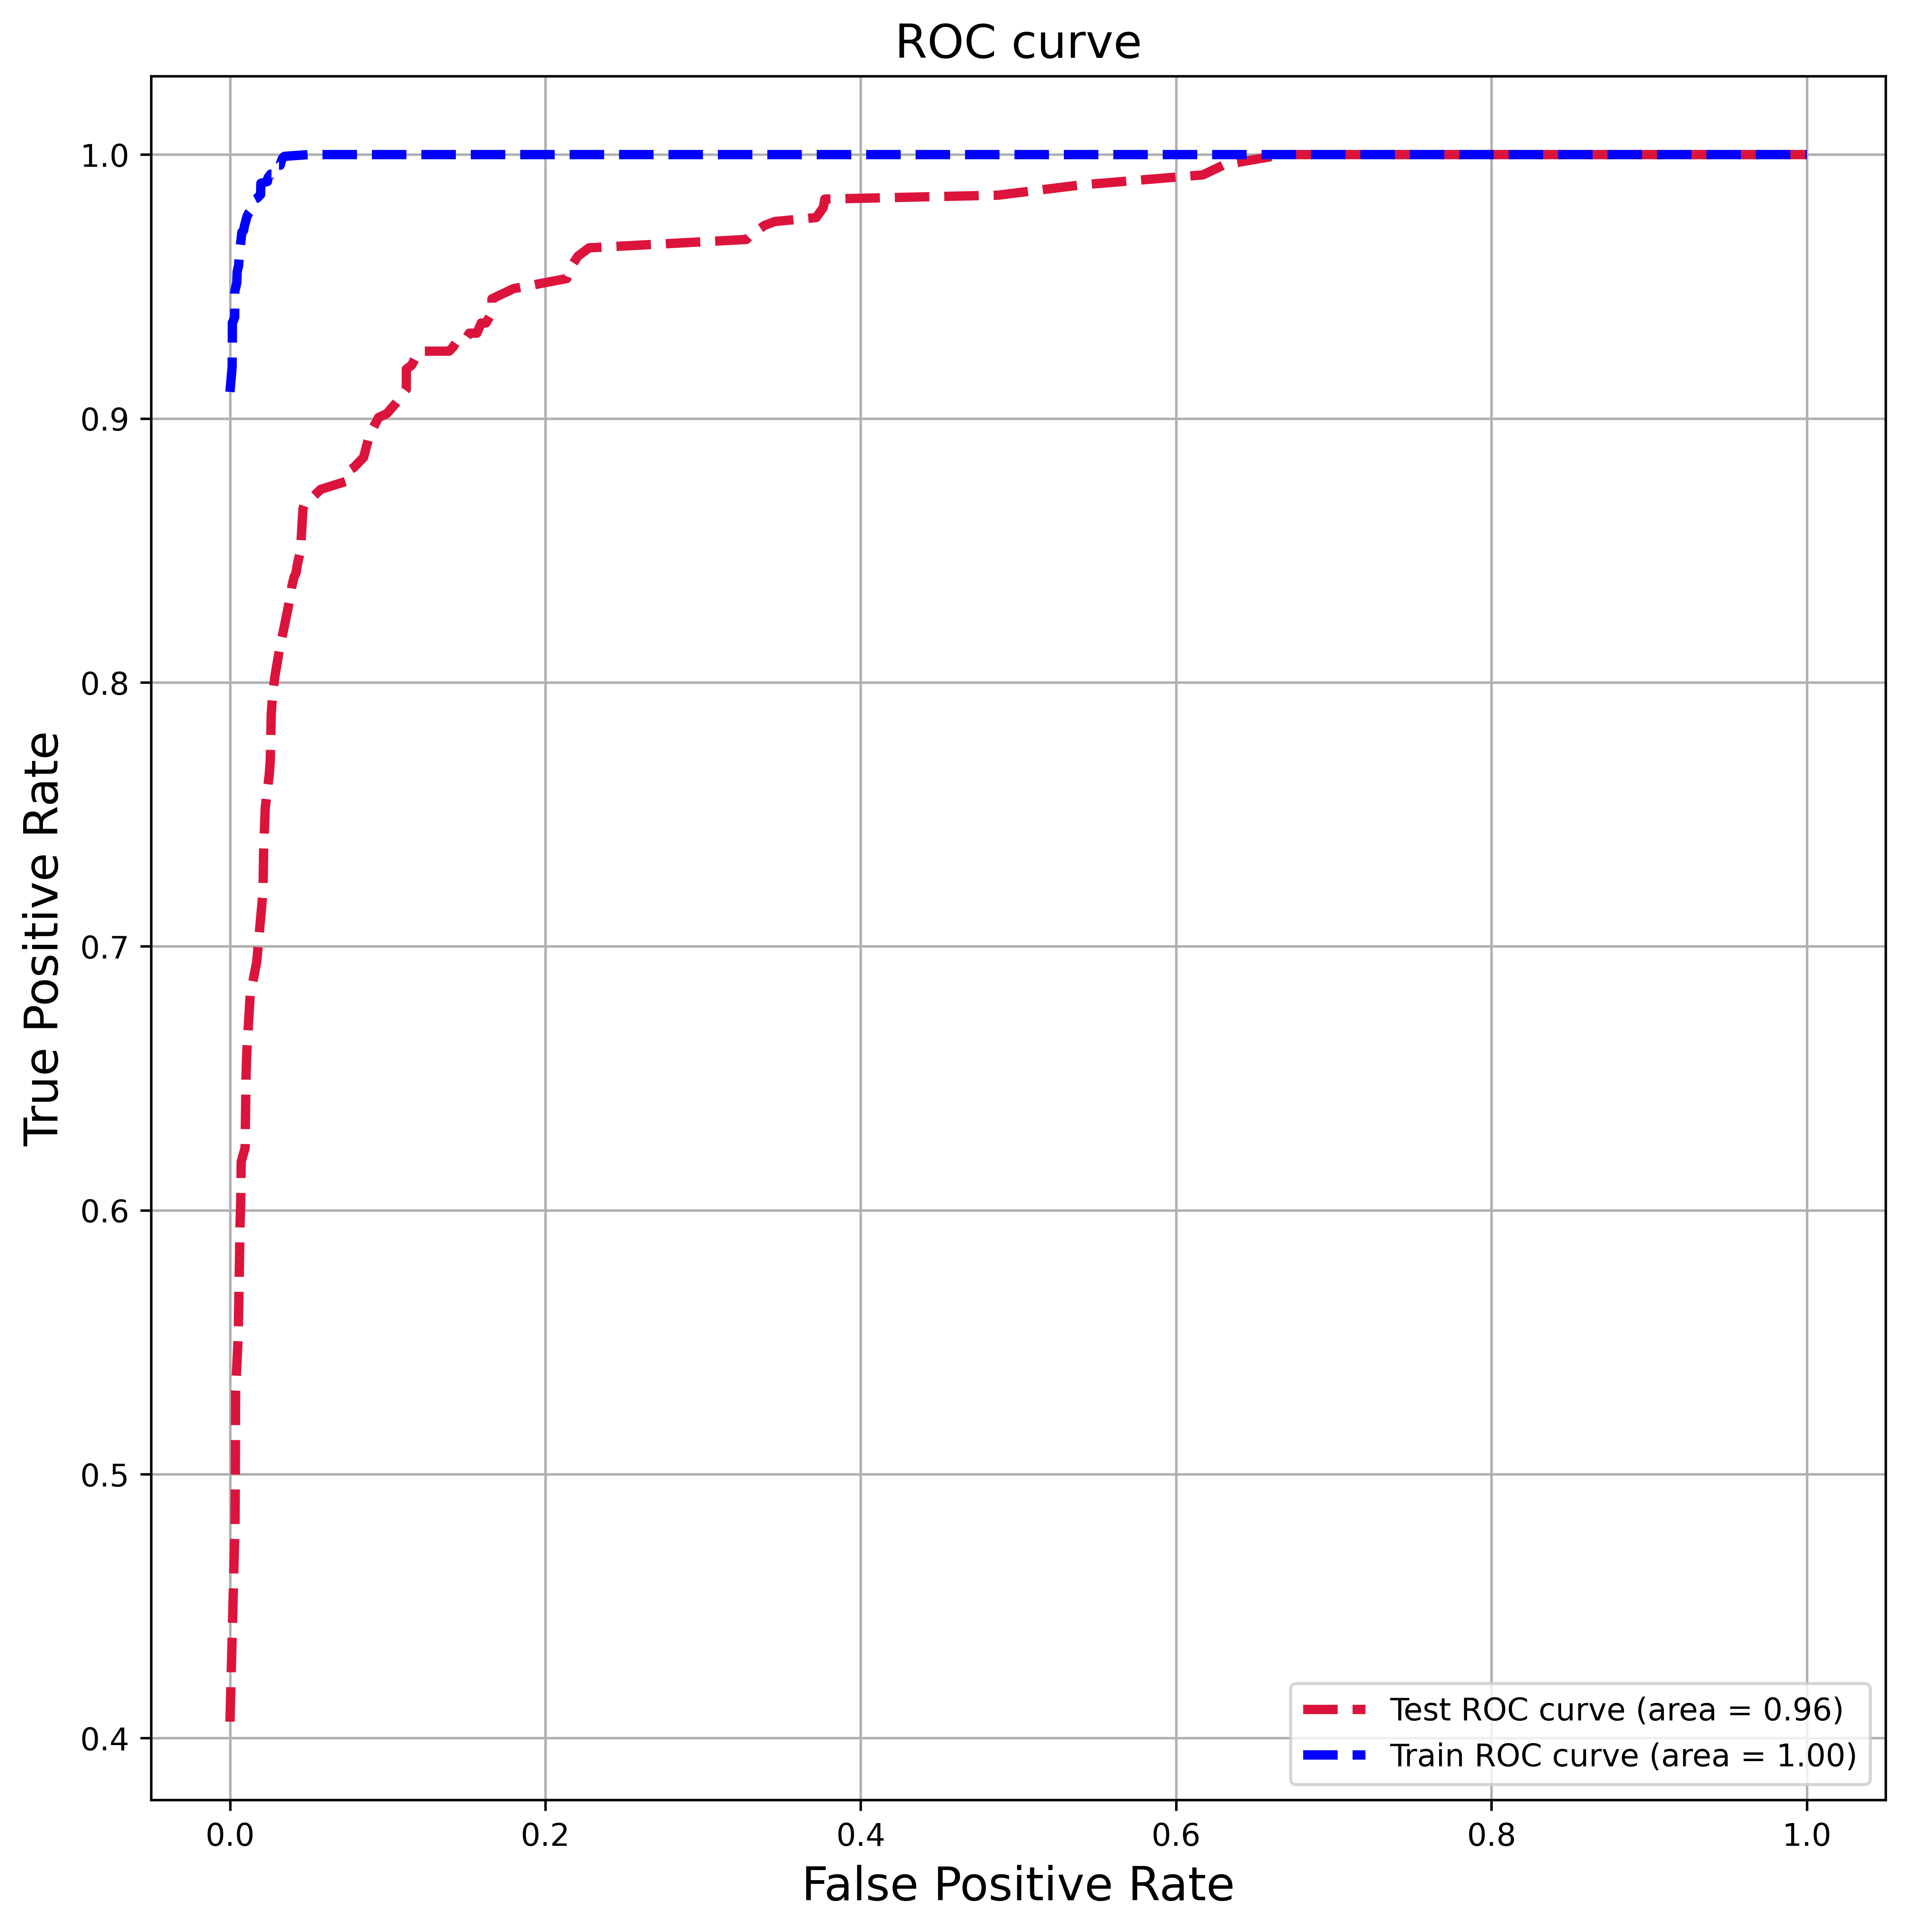

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy import interp

# Predict probabilities for both training and testing sets
y_score_test = final_model.predict_proba(Xtest)
y_score_train = final_model.predict_proba(Xtrain)

# Binarize the labels for both sets
y_test = label_binarize(Ytest, classes=[0, 1, 2, 3])  # Four classes
y_train = label_binarize(Ytrain, classes=[0, 1, 2, 3])  # Four classes

n_classes = y_test.shape[1]

# Calculate ROC curve and AUC for the testing set
fpr_test = dict()
tpr_test = dict()
roc_auc_test = dict()

for i in range(n_classes):
    fpr_test[i], tpr_test[i], _ = roc_curve(y_test[:, i], y_score_test[:, i])
    roc_auc_test[i] = auc(fpr_test[i], tpr_test[i])

# Compute macro-average ROC curve and ROC AUC for the testing set
all_fpr_test = np.unique(np.concatenate([fpr_test[i] for i in range(n_classes)]))
mean_tpr_test = np.zeros_like(all_fpr_test)

for i in range(n_classes):
    mean_tpr_test += interp(all_fpr_test, fpr_test[i], tpr_test[i])

mean_tpr_test /= n_classes
fpr_test["macro"] = all_fpr_test
tpr_test["macro"] = mean_tpr_test
roc_auc_test["macro"] = auc(fpr_test["macro"], tpr_test["macro"])

# Calculate ROC curve and AUC for the training set
fpr_train = dict()
tpr_train = dict()
roc_auc_train = dict()

for i in range(n_classes):
    fpr_train[i], tpr_train[i], _ = roc_curve(y_train[:, i], y_score_train[:, i])
    roc_auc_train[i] = auc(fpr_train[i], tpr_train[i])

# Compute macro-average ROC curve and ROC AUC for the training set
all_fpr_train = np.unique(np.concatenate([fpr_train[i] for i in range(n_classes)]))
mean_tpr_train = np.zeros_like(all_fpr_train)

for i in range(n_classes):
    mean_tpr_train += interp(all_fpr_train, fpr_train[i], tpr_train[i])

mean_tpr_train /= n_classes
fpr_train["macro"] = all_fpr_train
tpr_train["macro"] = mean_tpr_train
roc_auc_train["macro"] = auc(fpr_train["macro"], tpr_train["macro"])

plt.figure(figsize=(10, 10), dpi=600)

# Plot the ROC curve for the testing set
plt.plot(fpr_test["macro"], tpr_test["macro"],
         label='Test ROC curve (area = {0:0.2f})'
               ''.format(roc_auc_test["macro"]),
         color='crimson', linestyle='--', linewidth=3)

# Plot the ROC curve for the training set
plt.plot(fpr_train["macro"], tpr_train["macro"],
         label='Train ROC curve (area = {0:0.2f})'
               ''.format(roc_auc_train["macro"]),
         color='blue', linestyle='--', linewidth=3)

plt.xlabel('False Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
plt.title('ROC curve', fontsize=15)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True)
plt.savefig('ROC_t curve.png', dpi=1000, bbox_inches='tight')
plt.show()


In [76]:
# # 模型评价
# # 三、AUC
from sklearn import metrics
models =  [model_RF, model_SVC , model_GB, model_AB,model_xgboost,final_model]

def AUC_value(Ytest,Xtest,*models):
    for model in models:
        Y_pred_prob = model.predict_proba(Xtest)
        AUC = roc_auc_score(Ytest, Y_pred_prob, multi_class='ovr')
        print(AUC)

AUC_value(Ytest,Xtest, model_RF, model_SVC , model_GB, model_AB,model_xgboost,final_model)

0.9615185247942991
0.9677130282461157
0.9582063821577633
0.9398305622850811
0.9571815349142129
0.9658283888876964



from itertools import cycle
from scipy import interp
from sklearn.preprocessing import label_binarize
y_score = final_model.predict_proba(Xtest) 
# 将标签二值化
y = label_binarize(Ytest, classes=[0, 1, 2,3]) # 三个类别
 
# 设置种类
n_classes = y.shape[1]

# 计算每一类的ROC
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
 

#  Compute micro-average ROC curve and ROC area（方法二）
fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
 
# Compute macro-average ROC curve and ROC area（方法一）
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
 
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])
 

# Finally average it and compute AUC
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
 
# Plot all ROC curves
lw=2
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)
 
plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)
 
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

    
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()



In [22]:
# 模型评价
#四、绘制ROC曲线
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
import numpy as np

def multi_models_roc(names, models, colors, Xtest, Ytest, dpin=50):
    plt.figure(figsize=(20, 20), dpi=dpin)

    # Binarize the labels if they are not one-hot encoded
    lb = LabelBinarizer()
    Ytest_bin = lb.fit_transform(Ytest)

    for (name, model, colorname) in zip(names, models, colors):
        # For multi-class ROC, we need to use predict_proba to get class probabilities
        Ytest_predprob = model.predict_proba(Xtest)
        n_classes = Ytest_predprob.shape[1]

        # Compute macro-average ROC curve and AUC
        fpr_macro = np.zeros(100)
        tpr_macro = np.zeros(100)

        for i in range(n_classes):
            fpr, tpr, _ = roc_curve(Ytest_bin[:, i], Ytest_predprob[:, i])
            fpr_macro += np.interp(np.linspace(0, 1, 100), fpr, fpr)
            tpr_macro += np.interp(np.linspace(0, 1, 100), fpr, tpr)

        fpr_macro /= n_classes
        tpr_macro /= n_classes
        roc_auc_macro = auc(fpr_macro, tpr_macro)

        # Plot macro-average ROC curve
        plt.plot(fpr_macro, tpr_macro, lw=2, label='{} Macro-average (AUC={:.3f})'.format(name, roc_auc_macro), color=colorname)

    plt.plot([0, 1], [0, 1], '--', lw=2, color='grey')
    plt.axis('square')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.tick_params(labelsize=20)
    plt.xlabel('False Positive Rate', fontsize=20)
    plt.ylabel('True Positive Rate', fontsize=20)
    plt.title('ROC Curve_model', fontsize=20)
    plt.legend(loc='lower right', fontsize=15)
#     plt.savefig('ROC.png', dpi=1000, bbox_inches='tight')
    plt.show()




In [23]:
models =  [model_RF, model_SVC , model_GB, model_AB,model_xgboost,final_model]
names =['RF','SVC','GBT','AB','xgboost','Stacking' ]
colors = ['crimson',
          'orange',
          'gold',
          'mediumseagreen',
          'steelblue', 
          'mediumpurple'  
         ,'r']

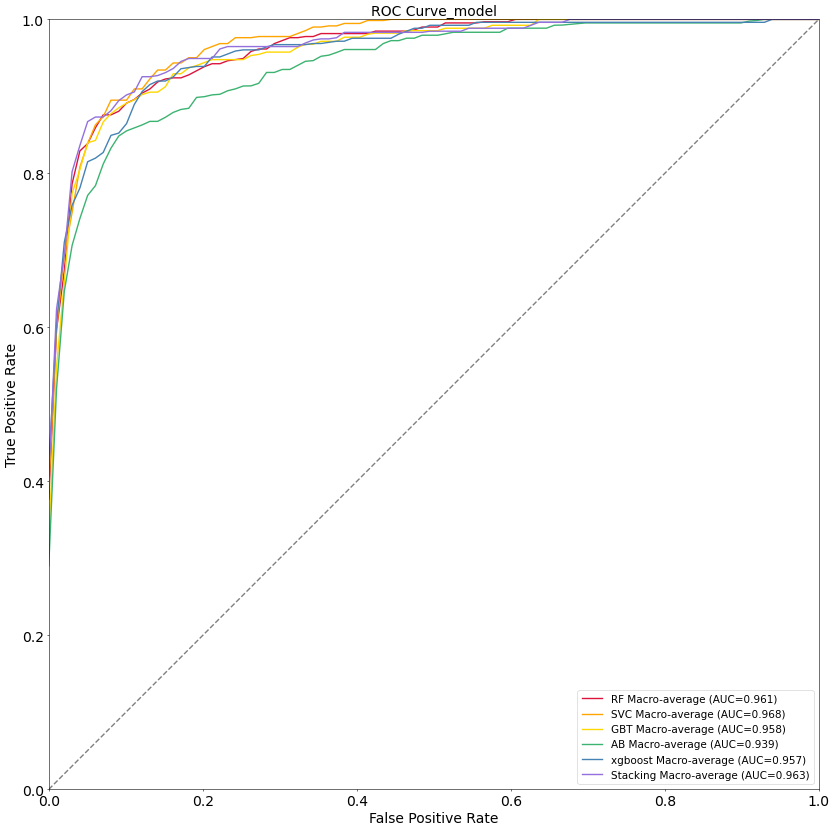

In [24]:
multi_models_roc(names, models, colors, Xtest, Ytest,)

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import precision_recall_curve, average_precision_score

def AP(Ytest, Ytest_predprob):
    # Calculate average precision (AP) for macro-average
    AP = average_precision_score(Ytest, Ytest_predprob, average='macro', sample_weight=None)
    return AP

def multi_models_PR(names, models, colors, Xtest, Ytest, dpin=50):
    plt.figure(figsize=(20, 20), dpi=dpin)

    # Binarize the labels if they are not one-hot encoded
    lb = LabelBinarizer()
    Ytest_bin = lb.fit_transform(Ytest)

    for (name, model, colorname) in zip(names, models, colors):
        # For multi-class PR, we need to use predict_proba to get class probabilities
        Ytest_predprob = model.predict_proba(Xtest)
        n_classes = Ytest_predprob.shape[1]

        # Compute macro-average PR curve and AP
        precision_macro = np.zeros(100)
        recall_macro = np.zeros(100)

        for i in range(n_classes):
            precision, recall, _ = precision_recall_curve(Ytest_bin[:, i], Ytest_predprob[:, i])
            precision_macro += np.interp(np.linspace(0, 1, 100), recall[::-1], precision[::-1])
            recall_macro += np.linspace(0, 1, 100)

        precision_macro /= n_classes
        recall_macro /= n_classes
        ap_macro = AP(Ytest_bin, Ytest_predprob)

        # Plot macro-average PR curve
        plt.plot(recall_macro, precision_macro, lw=2, label='{} Macro-average (AP={:.3f})'.format(name, ap_macro), color=colorname)

    plt.xlabel('Recall', fontsize=20)
    plt.ylabel('Precision', fontsize=20)
    plt.title('Precision-Recall Curve_model', fontsize=20)
    plt.legend(loc='lower left', fontsize=20)
#     plt.grid(True)
#     plt.savefig('PRcur.png', dpi=1000, bbox_inches='tight')
    plt.show()


In [26]:
colors = ['crimson',
          'orange',
          'gold',
          'mediumseagreen',
          'steelblue', 
          'mediumpurple'  
         ,'r']

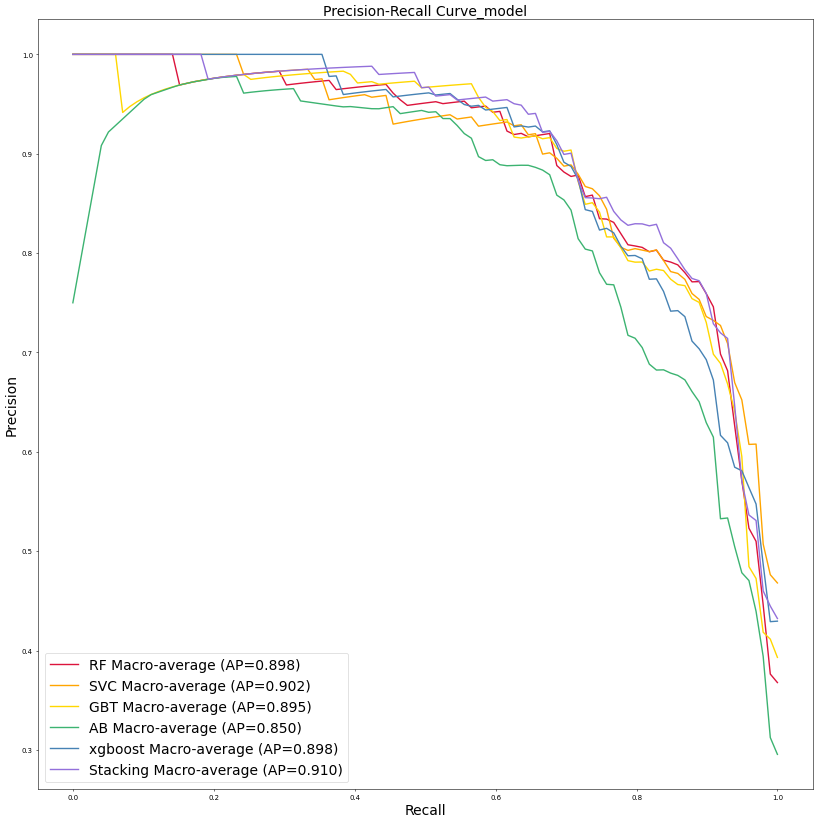

In [27]:
multi_models_PR(names, models, colors, Xtest, Ytest,)

In [28]:
# 5.1 获取特征排序均值
feat_impts = []
for clf in final_model.estimators_:
    feat_impts.append(clf.feature_importances_)

importances =np.mean(feat_impts, axis=0)
print(importances)

AttributeError: 'SVC' object has no attribute 'feature_importances_'

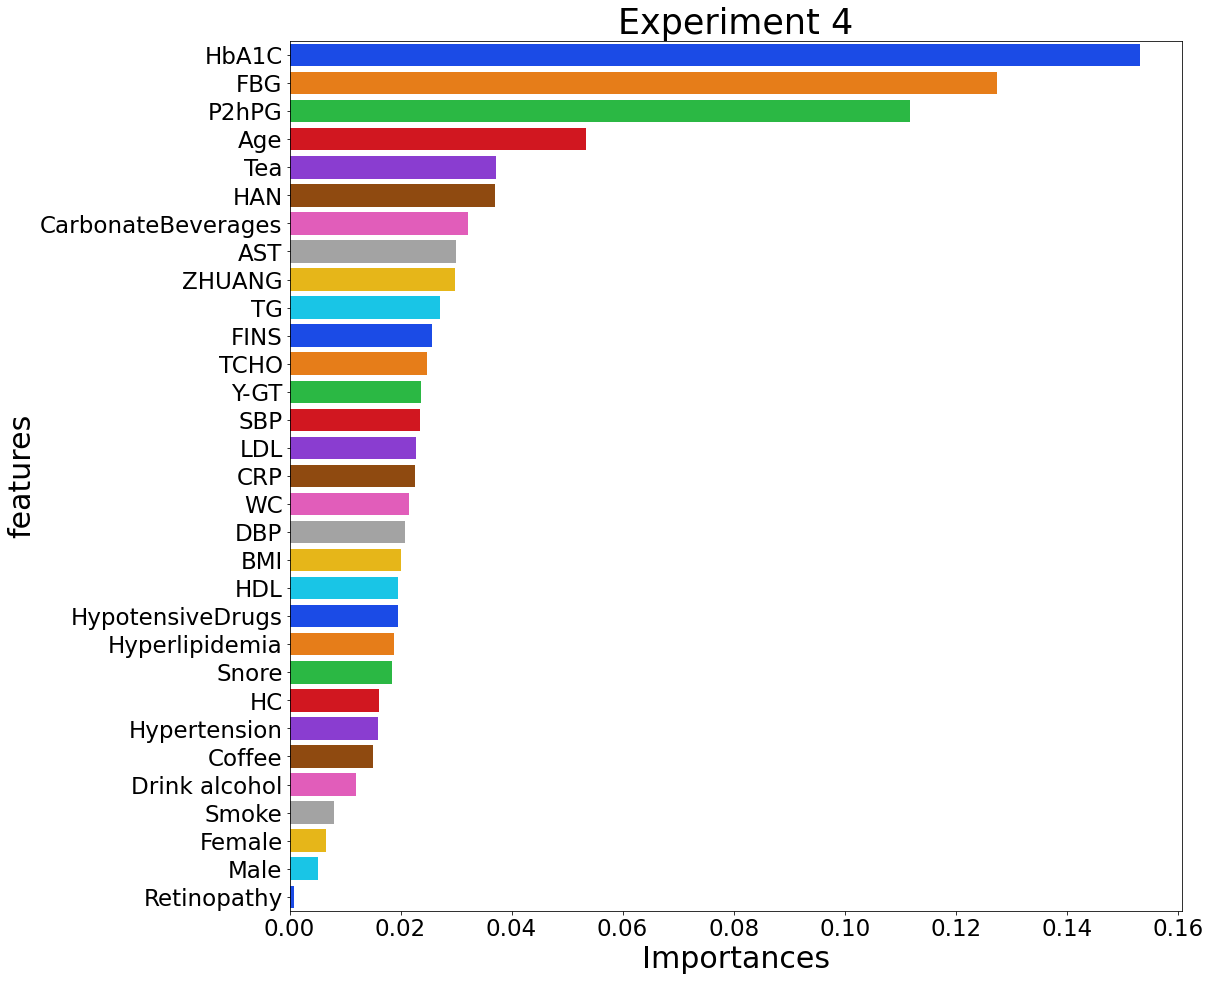

In [25]:
# 5.3 所有特征可视化
features = X.columns
data_tuples = list(zip(importances, features))
data = pd.DataFrame(data_tuples, columns = ['importances', 'features'])
data = data.sort_values('importances', ascending = False)
figure = plt.figure(figsize=(16,16))
#sns.barplot(x = data['importances'], y = data['features'], palette = 'Greens', orient = 'h').set_title(names[i]);
ax = sns.barplot(x = data['importances'], y = data['features'],palette = 'bright',orient = 'h',saturation=0.8)
plt.tick_params(labelsize=23)
plt.title('Experiment 4',fontsize=35)
plt.xlabel('Importances',fontsize=30)
plt.ylabel('features',fontsize=30)
plt.savefig('feature_importances.png',dpi=1000,bbox_inches = 'tight')
plt.show()

In [ ]:
#先查看树的深度，确定range 范围，
#固定其他参数，通过学习曲线找max_depth或max_feature最优值范围
#通过网格搜索找最优值，
#放入模型中，进行精调
#先处理过拟合train与cv_mean不能相差太大，否则就是过拟合，要降低max_depth或max_feature，
#确定好max_depth或max_feature，再使用网格搜索对n_estimators进行调整。
#尽量保证cv_mean和 test_score数据要好，cv_mean为第一目标
#cv_mean和 test_score相差不能超过0.01